# Oferecendo produtos similares a pessoas semelhantes
----

## Importando as bibliotecas necessárias

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## Análise Exploratória de Dados

In [3]:
electronics_data=pd.read_csv("/Users/carolinamartao/Desktop/Workshop Python/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Temos aqui:

User_id: é uma string alfanumérica para identificar o usuário 

prod_id: é uma string alfanumérica para identificar o produto

ratings: valor inteiro de 1 a 5

time stamp: data

In [6]:
# Linhas e Colunas
electronics_data.shape

(7824482, 4)

In [7]:
# Criando um subset para análise
electronics_data=electronics_data.iloc[:1048576,0:]

In [8]:
# Quais os tipos de dados temos?
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [9]:
#Encontrando as ratings máxima e mínima
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


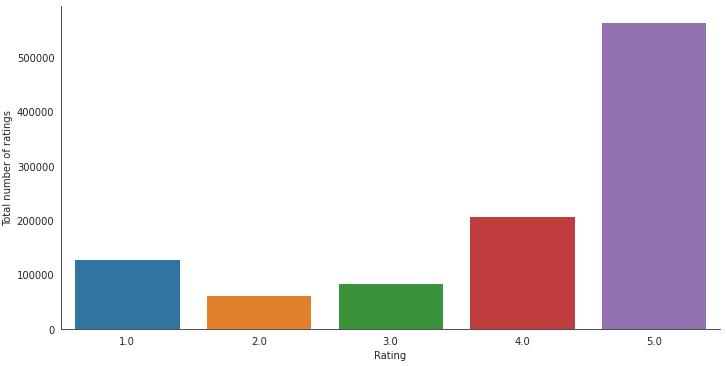

In [10]:
# Verificando a distribuição das ratings (volumetria)
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

## Usuários únicos e produtos

In [13]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))
print("Average number of Ratings by user  :", electronics_data.shape[0]/len(np.unique(electronics_data.userId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894
Average number of Ratings by user  : 1.3335062887083031


In [12]:
# Vamos eliminar a coluna de timstamp porque não estamos usando
electronics_data.drop(['timestamp'], axis=1,inplace=True)

## Modelo baseado no sistema de filtro colaborativo

Considera o nome do usuário e ID do produto para fazer previsões

É baseado em machine learning e data mining, onde treinamos modelos. Pode-se usar a interação usuário-item para predizer o top 5 itens que o usuário pode gostar e comprar.

In [17]:
new_df=electronics_data.head(10000)
ratings_matrix = new_df.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0132793040,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,...,B00000J1DN,B00000J1DT,B00000J1E6,B00000J1EC,B00000J1EJ,B00000J1EP,B00000J1EQ,B00000J1ES,B00000J1EZ,B00000J1F3
userId,,,,,,,,,,,,,,,,,,,,,
A00766851QZZUBOVF4JFT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A01255851ZO1U93P8RKGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0402564TCEO67AUZFJO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


A matriz gerada é esparsa, sendo preenchida com zeros os valores desconhecidos (matriz com muitos zeros)

In [18]:
# Transpondoi a matriz

X = ratings_matrix.T
X.head()

userId,A00766851QZZUBOVF4JFT,A01255851ZO1U93P8RKGE,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0402564TCEO67AUZFJO,A04256643L1ZMT75HVD2P,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A07865442XT0VEAVPSGX1,...,AZV9WA9MNT0FB,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXFQVG0PS3V1,AZYNQZ94U6VDB,AZYTSU42BZ7TP,AZZ77XYX8O2WE,AZZGUU97OHUF1,AZZMV5VT9W7Y8
productId,,,,,,,,,,,,,,,,,,,,,
0132793040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0321732944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0439886341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0511189877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
0528881469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Produtos únicos no dados do subset
X1 = X

## Recurso matemático: Singular Value Decomposition (SVD)


SVD é um método popular para redução de dimensionalidade. No entanto, funciona melhor com dados esparsos. Aqui, dados esparsos referem-se aos dados com muitos valores zero. Existem muitos casos em que dados esparsos são gerados, como em um sistema de recomendação de produtos em um site de e-commerce onde cada usuário pode dar uma classificação ou comentário. Mesmo assim, muitos deles deixaram a parcela em branco, o que gera valor zero nos dados.

In [21]:
#Decompondo a matriz
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1305, 10)

In [22]:
#Matriz de Correlação

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1305, 1305)

In [24]:
# Este index é o product id comprado pelo cliente
X.index[75]

'1600775160'

In [25]:
i = "1600775160"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [26]:
# Correlação para todos os itens com o item comprado pelo cliente, baseado no mesmo item comprado pelos clientes que rankearam
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1305,)

In [27]:
#Top 25 itens correlatos em sequencia:

Recommend = list(X.index[correlation_product_ID > 0.65])

# Removendo os itens já comprados
Recommend.remove(i) 

Recommend[0:24]

['0132793040',
 '0528881469',
 '0594012015',
 '0594017580',
 '0594033896',
 '0594450705',
 '0594549558',
 '0840017677',
 '089933623X',
 '0899336795',
 '094339676X',
 '0970407998',
 '0970408005',
 '0977703037',
 '0979526191',
 '1400699894',
 '1427695024',
 '1444501399',
 '1575839415',
 '1594243034',
 '1610130804',
 '1615543562',
 '1615598774',
 '1615598790']

Collaboration Filtering recomenda um item para um usuário se seus vizinhos (outros usuários semelhantes a ele) estiverem interessados ​​em tal item. Observe que a avaliação do usuário em um item expressa seu interesse. Todas as classificações dos usuários sobre os itens compõem a chamada matriz de classificação.